# pytesseract 모델을 사용한 자동차 번호판 인식 코드입니다. (인식 실패 사례)

In [171]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

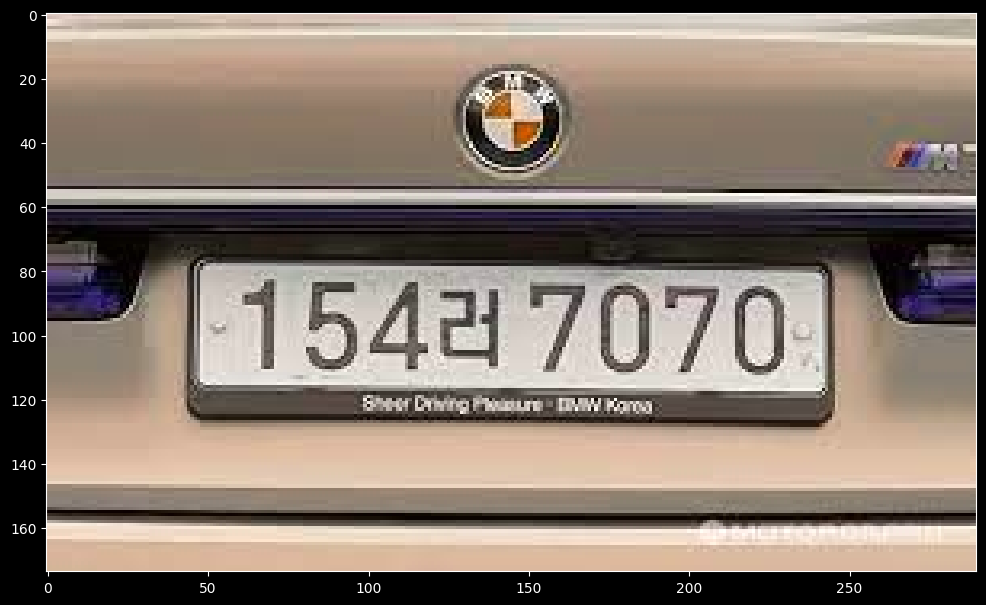

In [194]:
img_ori = cv2.imread('./1.jpeg')

height, width, channel = img_ori.shape

plt.figure(figsize=(12,10))
plt.imshow(img_ori, cmap='gray')

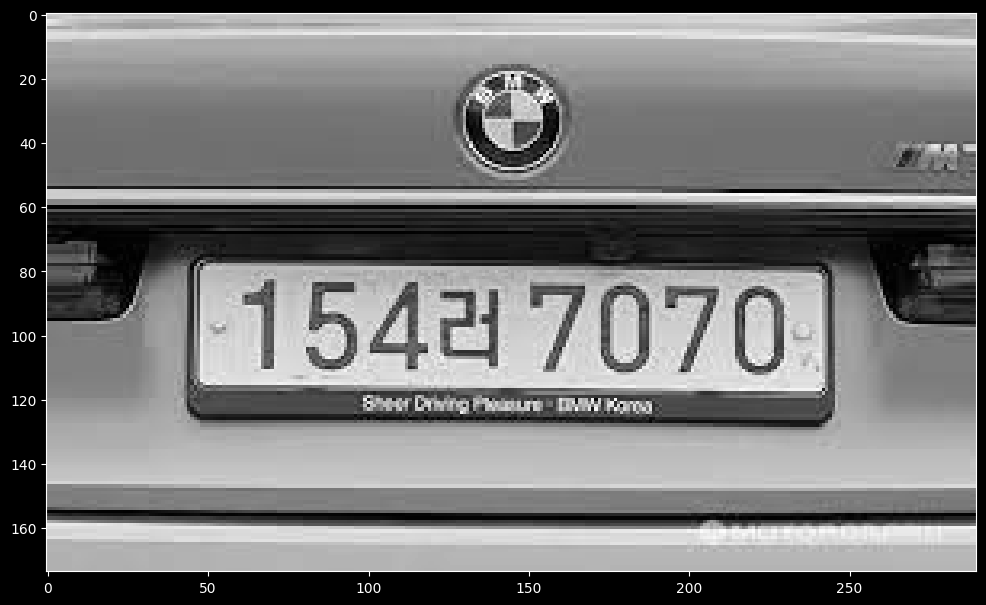

In [195]:
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,10))
plt.imshow(gray, cmap='gray')

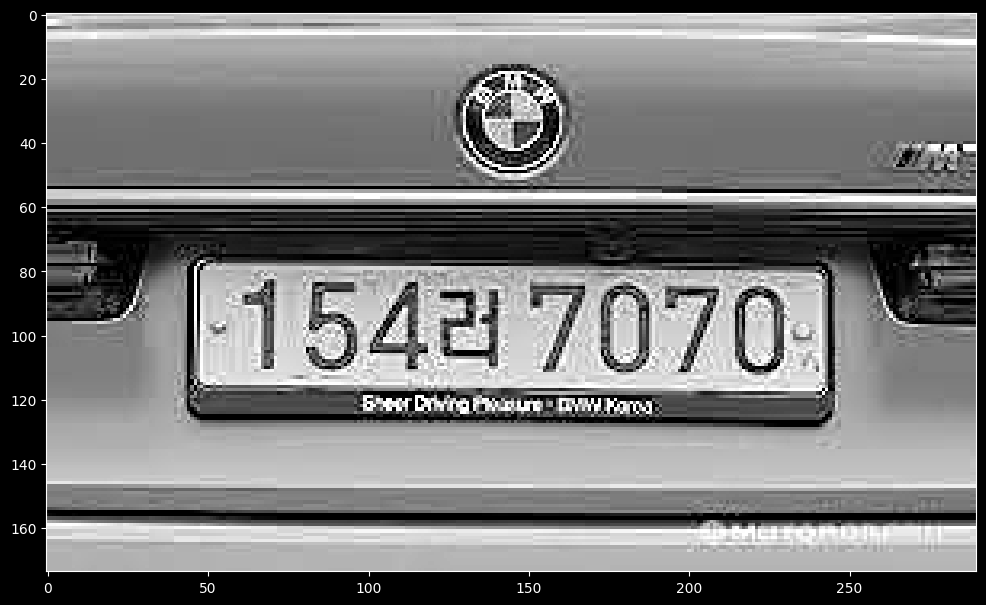

In [196]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

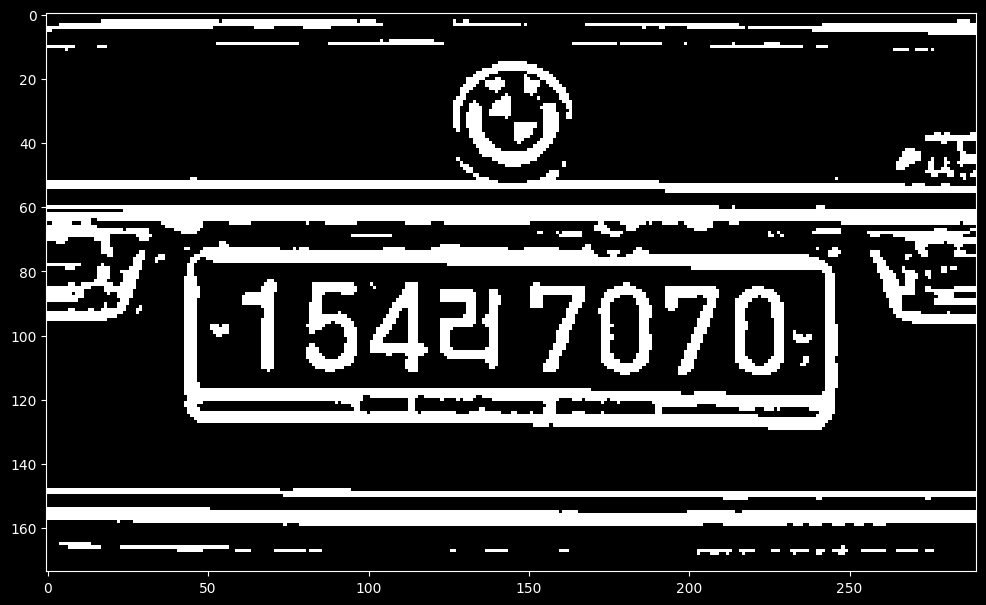

In [197]:
#GaussianBlur: 노이즈를 줄이기 위해서
#adaptiveThreshold: 이미지 구별 쉽게 0 or 255 로 (검정 or 흰색으로)

img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

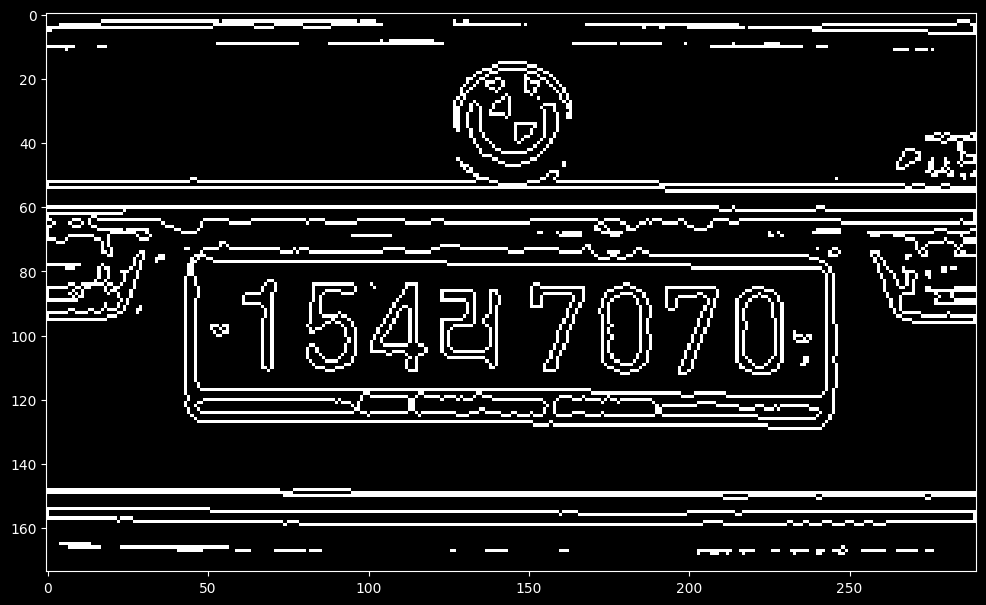

In [198]:
contours, _ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

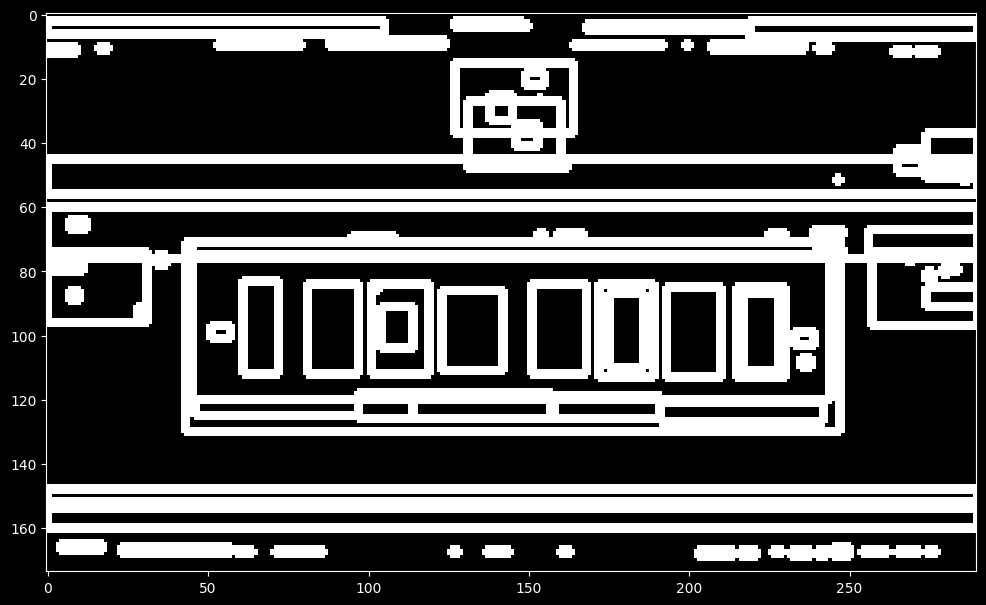

In [199]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

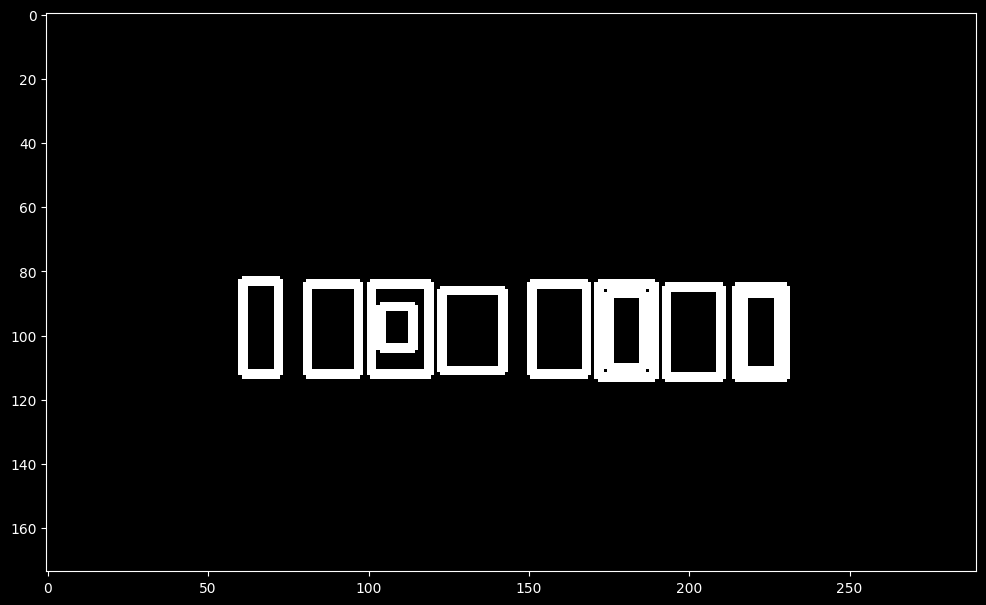

In [200]:
MIN_AREA = 40   # 번호판 윤곽선 최소 범위 지정
MIN_WIDTH, MIN_HEIGHT = 2, 8         # 최소 너비 높이 범위 지정
MIN_RATIO, MAX_RATIO = 0.25, 1.0     # 최소 비율 범위 지정

possible_contours = []  # possible_contours에 저장

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    
  # 위에 설정한 범위의 조건을 비교, 맞추면서 다시한번 possible_contours에 저장해준다. 
  # 각 윤곽선의 idx값을 매겨놓고, 나중에 조건에 맞는 윤곽선들의 idx만 따로 빼낼 것이다.  d['idx'] = cnt
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
# possible contours의 정렬방식을 보고 번호판 후보들을 추려낸다. 번호판은 어느정도 규칙적으로 일렬로 나타난다. 순차적,각도,배열모양..
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

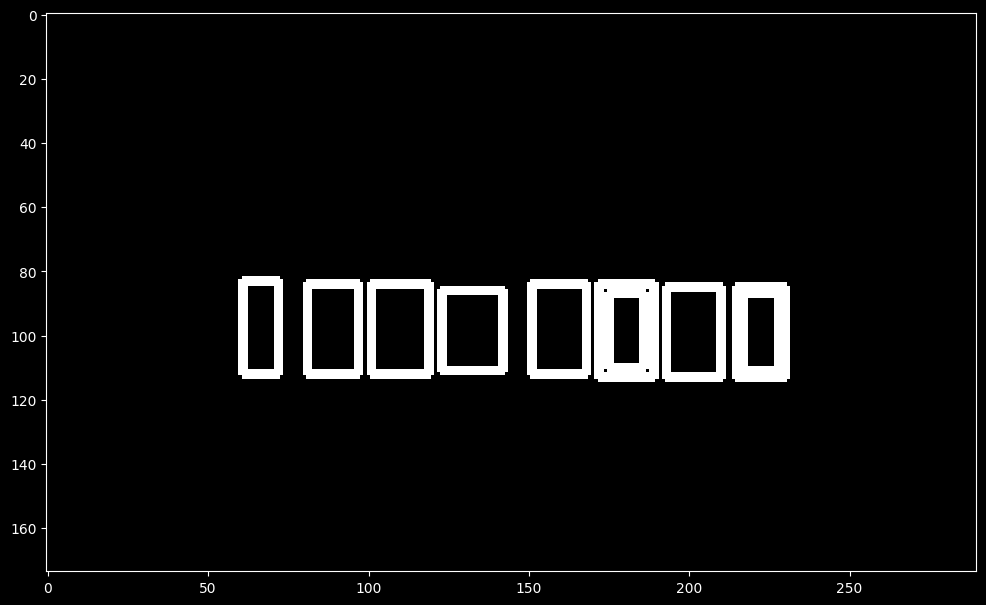

In [201]:
MAX_DIAG_MULTIPLYER = 5 # 5  대각선길이
MAX_ANGLE_DIFF = 12.0 # 12.0  1번째 contour와 2번째 contour 의 각도
MAX_AREA_DIFF = 0.5 # 0.5  면적의 차이
MAX_WIDTH_DIFF = 0.8 # 너비 차이
MAX_HEIGHT_DIFF = 0.2 # 높이 차이
MIN_N_MATCHED = 3 # 3 # 위에 조건들이 3개이상 충족해야 번호판이다

# find_chars 함수로 지정한다. 나중에 재귀함수로 반복해서 찾기 위함이다. idx값 저장

def find_chars(contour_list):
    matched_result_idx = []
    
    
# 이중for문으로 예를들면 첫번째 contour와 두번째 contour를 비교

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            
# np.linalg.norm(a - b) 벡터 a와 벡터 b 사이의 거리를 구한다.
# 삼각함수 사용
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h']) #면적의 비율
            width_diff = abs(d1['w'] - d2['w']) / d1['w'] # 너비의 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h'] # 높이의 비율

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        # 번호판 후보군의 윤곽선 개수가 3보다 작으면 번호판일 확률이 낮다. 이유는 한국 번호판은 총 7자리 이기 때문이다.
        matched_contours_idx.append(d1['idx'])
        # 육관선 개수가 3보다 작을때는 continue를 통해 제외
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue
        # 최종 호부군에 넣어주기
        matched_result_idx.append(matched_contours_idx)
        # 아닌 것들을 다시 한번 비교하고 넣어준다.
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

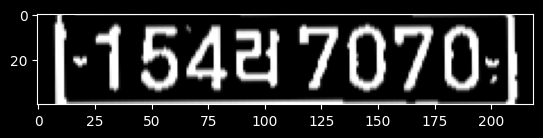

In [202]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])
    # 센터 좌표 구하기
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    # 번호판의 기울어진 각도를 구하기 (삼각함수 이용)
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    # cv2.getRotationMatrix2D() 로테이션매트릭스를 구한다.
    # cv2.warpAffine() 이미지를 변현한다.
    # cv2.getRectSubPix() 회전된 이미지에서 원하는 부분만을 잘라낸다.
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

In [192]:
print(plate_infos)

[{'x': 128, 'y': 80, 'w': 67, 'h': 14}]


-----------------------------------------------

### 

# 아래 코드가 자동차 번호판을 인식하는데 성공한 코드입니다. 
## easyocr 모델을 사용하였습니다.

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


인식된 번호판: 45가64923


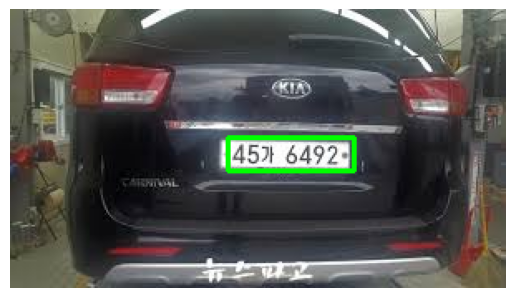

In [22]:
import cv2
import easyocr
import re
import matplotlib.pyplot as plt

def recognize_license_plate(image_path):

    img = cv2.imread(image_path)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    reader = easyocr.Reader(['ko'])  
    
    results = reader.readtext(gray)
    
    pattern = re.compile("[가-힣0-9]+")
    
    results.sort(key=lambda x: x[2], reverse=True)
    for (bbox, text, prob) in results:
        # 정규식에 맞는 문자열만 출력
        filtered_text = "".join(pattern.findall(text))
        if filtered_text:
            (top_left, top_right, bottom_right, bottom_left) = bbox
            top_left = tuple(map(int, top_left))
            bottom_right = tuple(map(int, bottom_right))
            img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)
            
            print(f"인식된 번호판: {filtered_text}")
            break
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # 축 제거
    plt.show()

if __name__ == "__main__":
    # 이미지 파일 경로 입력
    image_path = "./auto1.3/6.jpeg"
    recognize_license_plate(image_path)


# 인식 박스 크기 조정한 코드

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


인식된 번호판: 절96사2268


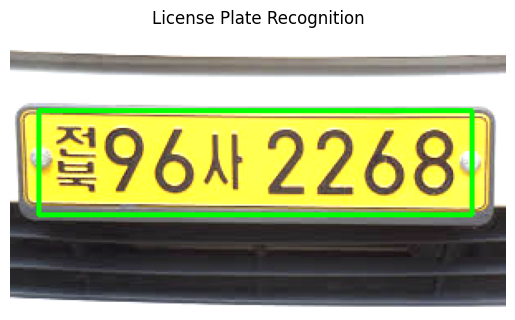

In [25]:
import cv2
import easyocr
import re
import matplotlib.pyplot as plt

def adjust_contrast(image, factor=1.3):
    # 이미지 대비 조정
    return cv2.convertScaleAbs(image, alpha=factor, beta=0)

def recognize_license_plate(image_path):
    # 이미지 불러오기
    img = cv2.imread(image_path)

    # 이미지 대비 조정
    img = adjust_contrast(img)

    # 이미지를 그레이스케일로 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # EasyOCR을 사용하여 번호판 인식
    reader = easyocr.Reader(['ko'])  # 'ko'는 한국어 언어 모델을 사용함을 의미합니다

    # 번호판 인식
    results = reader.readtext(gray)

    # 숫자와 한글만 포함된 번호판 패턴 정의
    pattern = re.compile("[가-힣0-9]+")

    # 신뢰도에 따라 정렬된 결과 중 가장 높은 신뢰도의 결과만 출력
    results.sort(key=lambda x: x[2], reverse=True)
    for (bbox, text, prob) in results:
        # 정규식에 맞는 문자열만 출력
        filtered_text = "".join(pattern.findall(text))
        if filtered_text:
            (top_left, top_right, bottom_right, bottom_left) = bbox
            top_left = tuple(map(int, top_left))
            bottom_right = tuple(map(int, bottom_right))
            img = cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)
            # img = cv2.putText(img, filtered_text, (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            print(f"인식된 번호판: {filtered_text}")
            break  # 가장 높은 신뢰도의 결과만 출력하고 반복문 종료

    # 결과 이미지를 matplotlib을 사용하여 출력
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("License Plate Recognition")
    plt.axis('off')  # 축 제거
    plt.show()

if __name__ == "__main__":
    # 이미지 파일 경로 입력
    image_path = "./auto1.3/19.jpeg"
    recognize_license_plate(image_path)


In [4]:
import os
import cv2
import easyocr
import re
import matplotlib.pyplot as plt

def adjust_contrast(image, factor=1.3):
    # 이미지 대비 조정
    return cv2.convertScaleAbs(image, alpha=factor, beta=0)

def process_images_in_folder(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    reader = easyocr.Reader(['ko'])

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)

        img = cv2.imread(image_path)

        img = adjust_contrast(img)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        results = reader.readtext(gray)

        pattern = re.compile("[가-힣0-9]+")
        
        results.sort(key=lambda x: x[2], reverse=True)
        for (bbox, text, prob) in results:
            # 정규식에 맞는 문자열만 출력
            filtered_text = "".join(pattern.findall(text))
            if filtered_text.isdigit():
                print(f"인식이 올바르지 않습니다. ({image_file}): {filtered_text}")
                break
            else:
                print(f"인식된 번호판 ({image_file}): {filtered_text}")
                break
        else:
            print(f"인식되지 못했습니다. ({image_file})")

if __name__ == "__main__":
    input_folder_path = "./auto1.3"  
    process_images_in_folder(input_folder_path)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


인식된 번호판 (1-4.jpeg): 355구2906
인식된 번호판 (1-5.jpeg): 123가4568
인식된 번호판 (1.jpeg): 154러7070
인식이 올바르지 않습니다. (14.jpg): 03
인식된 번호판 (15.jpg): 123가4568
인식된 번호판 (19.jpeg): 절96사2268
인식된 번호판 (2.jpeg): 381마8947
인식된 번호판 (3.jpeg): 50노6821
인식된 번호판 (4.jpeg): 60라7213
인식된 번호판 (6.jpeg): 45가6492


# 최종 코드!!

In [24]:
import os
import cv2
import easyocr
import re
import json
from datetime import datetime
def adjust_contrast(image, factor=1.3):
    # 이미지 대비 조정
    return cv2.convertScaleAbs(image, alpha=factor, beta=0)
def process_images_in_folder(folder_path, output_json_path):
    # 지정한 폴더에서 모든 파일 목록을 가져옴
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    # EasyOCR 리더 초기화
    reader = easyocr.Reader(['ko'])
    results_list = []  # 결과를 저장할 리스트
    for image_file in image_files:
        # 이미지 파일 경로 생성
        image_path = os.path.join(folder_path, image_file)
        # 이미지 불러오기
        img = cv2.imread(image_path)
        # 이미지 대비 조정
        img = adjust_contrast(img)
        # 이미지를 그레이스케일로 변환
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # 번호판 인식
        results = reader.readtext(gray)
        # 숫자와 한글만 포함된 번호판 패턴 정의
        pattern = re.compile("[가-힣0-9]+")
        # 신뢰도에 따라 정렬된 결과 중 가장 높은 신뢰도의 결과만 출력
        results.sort(key=lambda x: x[2], reverse=True)
        for (bbox, text, prob) in results:
            # 정규식에 맞는 문자열만 출력
            filtered_text = "".join(pattern.findall(text))
            if filtered_text.isdigit():
                print(f"인식이 올바르지 않습니다. ({image_file}): {filtered_text}")
            else:
                print(f"인식된 번호판 ({image_file}): {filtered_text}")
                # JSON으로 저장할 정보 구성
                result_info = {
                    "이미지명": image_file,
                    "이미지형식": image_file.split('.')[-1],
                    "X축 위치": int(bbox[0][0]),  # bbox[0]에서 X 좌표 추출
                    "Y축 위치": int(bbox[0][1])   # bbox[0]에서 Y 좌표 추출
                }
                results_list.append(result_info)
                break
        else:
            print(f"인식되지 못했습니다. ({image_file})")
    # JSON 파일로 저장
    dataset_info = {
        "데이터셋이름": "인식된 번호판 데이터셋",
        "데이터셋설명": "번호판 이미지와 해당 번호판 번호를 포함한 데이터셋",
        "데이터셋출처": "다나와 중고차 (https://auto.danawa.com/usedcar/?Work=list&Tab=list), 구글 이미지 ",
        "작성자정보": "강형근, 울지바야르",
        "생성일자": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "이미지정보": results_list
    }
    with open(output_json_path, 'w', encoding='utf-8') as json_file:
        json.dump(dataset_info, json_file, ensure_ascii=False, indent=4)
if __name__ == "__main__":
    # 이미지 파일이 있는 폴더 경로 입력
    input_folder_path = "./auto1.3"  # 실제 폴더 경로로 대체해주세요
    # 결과를 저장할 JSON 파일 경로
    output_json_path = "recognized_plates.json"
    process_images_in_folder(input_folder_path, output_json_path)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


인식된 번호판 (1-4.jpeg): 355구2906
인식된 번호판 (1-5.jpeg): 123가4568
인식된 번호판 (1.jpeg): 154러7070
인식이 올바르지 않습니다. (14.jpg): 03
인식된 번호판 (14.jpg): 403주29759
인식된 번호판 (15.jpg): 123가4568
인식된 번호판 (19.jpeg): 절96사2268
인식된 번호판 (2.jpeg): 381마8947
인식된 번호판 (3.jpeg): 50노6821
인식된 번호판 (4.jpeg): 60라7213
인식된 번호판 (6.jpeg): 45가6492


In [11]:
import easyocr

print(easyocr.__version__)


1.7.1


# -----------------------------------------------------------------------------------

-------------------

# 여기까지가 보고서에 들어가는 코드